In [3]:
import multiprocessing
import pandas as pd
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import xgboost as xgb

In [4]:
# reading the data
df_heart=pd.read_csv('../../statistics-and-machine-learning-learning/data/framingham.csv')
#df_heart.replace(np.nan,"NaN")
df_heart.dropna(axis=0,inplace=True)

##separation in X and y
X_heart = df_heart.drop( columns = "TenYearCHD" )
y_heart = df_heart[ "TenYearCHD" ]

In [5]:
X_heart.shape

(3658, 15)

# a simple XGBoost classifier

In [6]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

xgb_model.fit(X_heart, y_heart)

pd.crosstab( y_heart, xgb_model.predict(X_heart) ,  rownames=['true'], colnames=['predicted'] )


predicted,0,1
true,,
0,3101,0
1,38,519


We can integrate this classifier seemlessly in other sklearn routine such as gridSearchCV:

In [7]:
%%time

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count()-2)

# Make sure the number of threads is balanced.
clf = GridSearchCV(
    xgb_model,
    {"max_depth": [2, 4, 6], "n_estimators": [50, 100, 200], 'eta' : [0.01,0.1,1.0]},
    scoring='roc_auc',
    verbose=1,
    n_jobs=1,
)
clf.fit(X_heart, y_heart)
print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0.7150595776267819
{'eta': 0.1, 'max_depth': 2, 'n_estimators': 50}
CPU times: user 47.7 s, sys: 174 ms, total: 47.9 s
Wall time: 7.76 s



# tree method and max bin number: 

[treemethod](https://xgboost.readthedocs.io/en/stable/treemethod.html)

exact , approx, hist, corresponding to different degrees of speed and performance.



 * `approx` or `hist` should generally be prefered
 * Most of the time using hist with higher `max_bin` can achieve similar or even superior accuracy while maintaining good performance.





In [9]:
from sklearn.model_selection import cross_val_score
import numpy as np
from time import time

time_list = []
scores = []
mb_list = []
nrep = 4
for mb in np.arange(10,1024,50):

    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count(),
        tree_method="hist" , max_bin = mb , eval_metric = 'auc' )

    for i in range(nrep):
        t1 = time()
        cv_score = cross_val_score(xgb_model , X_heart,y_heart , cv = 5, scoring='roc_auc')
        time_list.append( time()-t1 )
        scores.append( cv_score.mean() )
        mb_list.append( mb )

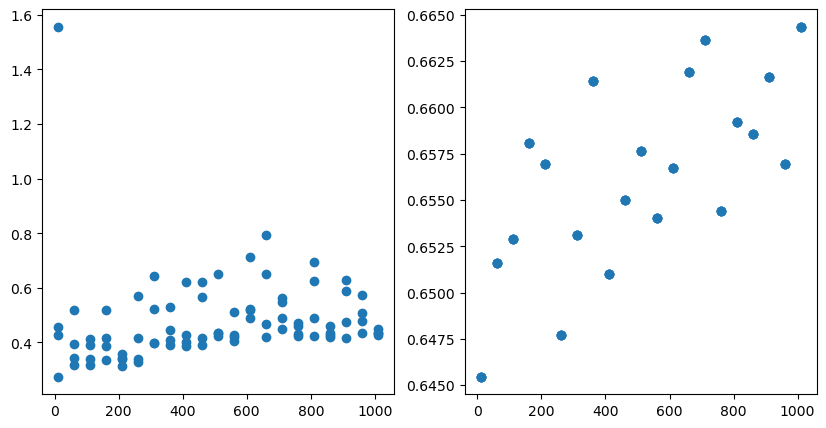

In [10]:
fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].scatter( mb_list , time_list )
ax[1].scatter( mb_list , scores )

# XGBoost number of estimators, eta,  and validation

In [11]:
##let's start by splitting the data into a train and a validaiton set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_valid, y_train, y_valid = train_test_split(X_heart, y_heart, stratify=y_heart, random_state=94)

In [12]:
xgb_model = xgb.XGBClassifier(tree_method="hist", 
                        eval_metric = "auc", n_estimators=10)

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)] )

[0]	validation_0-auc:0.79056	validation_1-auc:0.66836
[1]	validation_0-auc:0.80151	validation_1-auc:0.67120
[2]	validation_0-auc:0.84119	validation_1-auc:0.68429
[3]	validation_0-auc:0.85657	validation_1-auc:0.69019
[4]	validation_0-auc:0.86904	validation_1-auc:0.69190
[5]	validation_0-auc:0.87594	validation_1-auc:0.69214
[6]	validation_0-auc:0.88103	validation_1-auc:0.69348
[7]	validation_0-auc:0.89030	validation_1-auc:0.69517
[8]	validation_0-auc:0.89840	validation_1-auc:0.68781
[9]	validation_0-auc:0.90548	validation_1-auc:0.68899


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [13]:
xgb_model.evals_result_

{'validation_0': OrderedDict([('auc',
               [0.7905597571641714,
                0.8015120646190256,
                0.841185368112363,
                0.8565735453002007,
                0.8690363739260174,
                0.8759391881463189,
                0.8810284508926275,
                0.8902978854761537,
                0.8984035602201986,
                0.9054833564850543])]),
 'validation_1': OrderedDict([('auc',
               [0.668364792701921,
                0.6712016984350664,
                0.6842876214492324,
                0.6901885707928502,
                0.6919036935400134,
                0.6921401023511088,
                0.6934751168137655,
                0.6951716976933917,
                0.6878059408143589,
                0.6889879848698361])])}

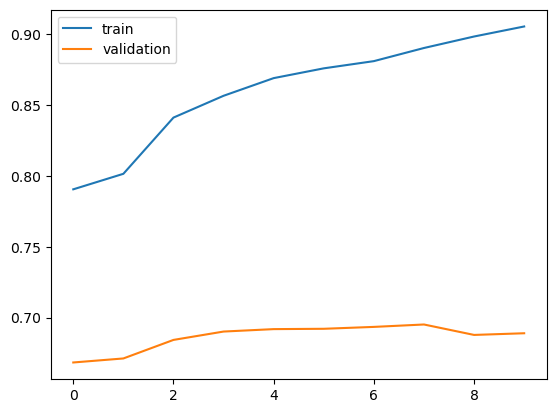

In [14]:
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

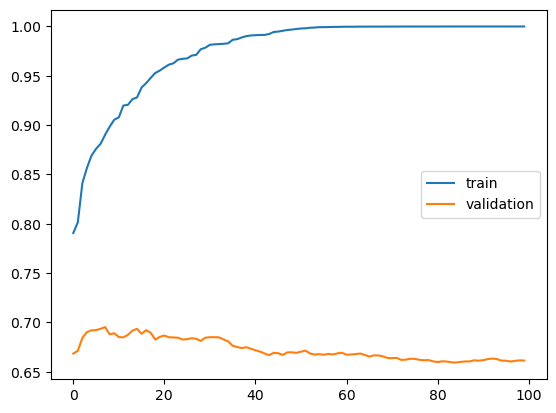

In [15]:
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    eta = 0.3 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

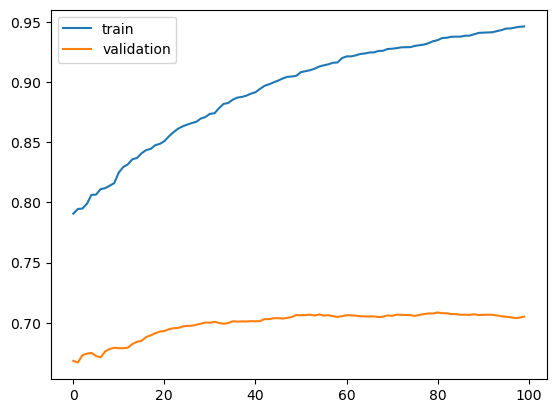

In [16]:
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.05 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

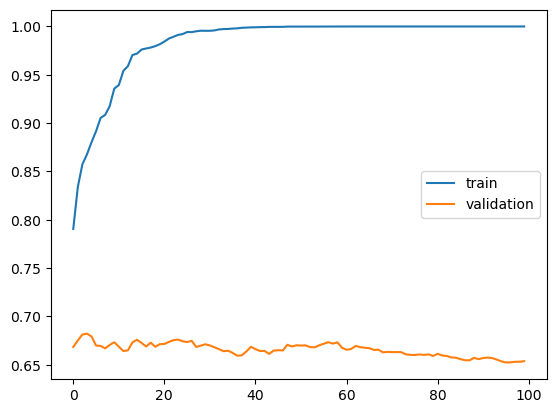

In [17]:
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.5 , n_estimators=100 , 
    eval_metric= 'auc' )

xgb_model.fit(X_train , y_train  , 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=False )
    
plt.plot( xgb_model.evals_result_['validation_0']['auc'] , label='train')
plt.plot( xgb_model.evals_result_['validation_1']['auc'] , label='validation')
plt.legend()

In [18]:
## early stopping

clf = xgb.XGBClassifier(tree_method="hist", 
                        early_stopping_rounds=5 , 
                        eval_metric = "auc",
                        eta = 0.05 )
clf.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_valid, y_valid)])

[0]	validation_0-auc:0.79056	validation_1-auc:0.66836
[1]	validation_0-auc:0.79448	validation_1-auc:0.66697
[2]	validation_0-auc:0.79479	validation_1-auc:0.67297
[3]	validation_0-auc:0.79879	validation_1-auc:0.67434
[4]	validation_0-auc:0.80620	validation_1-auc:0.67491
[5]	validation_0-auc:0.80635	validation_1-auc:0.67235
[6]	validation_0-auc:0.81098	validation_1-auc:0.67121
[7]	validation_0-auc:0.81173	validation_1-auc:0.67614
[8]	validation_0-auc:0.81383	validation_1-auc:0.67823
[9]	validation_0-auc:0.81594	validation_1-auc:0.67917
[10]	validation_0-auc:0.82477	validation_1-auc:0.67885
[11]	validation_0-auc:0.82941	validation_1-auc:0.67880
[12]	validation_0-auc:0.83158	validation_1-auc:0.67930
[13]	validation_0-auc:0.83580	validation_1-auc:0.68235
[14]	validation_0-auc:0.83680	validation_1-auc:0.68419
[15]	validation_0-auc:0.84073	validation_1-auc:0.68499
[16]	validation_0-auc:0.84334	validation_1-auc:0.68808
[17]	validation_0-auc:0.84438	validation_1-auc:0.68953
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eta=0.05, eval_metric='auc',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [19]:
clf.best_iteration , clf.best_score #  These are used by the predict() 

(54, 0.7068716161091745)

Early stopping is great to balance the number of estimators and eta, but, as noted in the [XGBoost doc](https://xgboost.readthedocs.io/en/stable/python/sklearn_estimator.html#early-stopping):

"""
 However, using **early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model.** A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. If you want to experiment with idea of using cross validation with early stopping, here is a snippet to begin with:. However, using early stopping during cross validation may not be a perfect approach because it changes the model’s number of trees for each validation fold, leading to different model. A better approach is to retrain the model after cross validation using the best hyperparameters along with early stopping. 
 
 """


We can use it here to evaluate the effect of `eta`:

CPU times: user 14.7 s, sys: 68.1 ms, total: 14.8 s
Wall time: 2.4 s


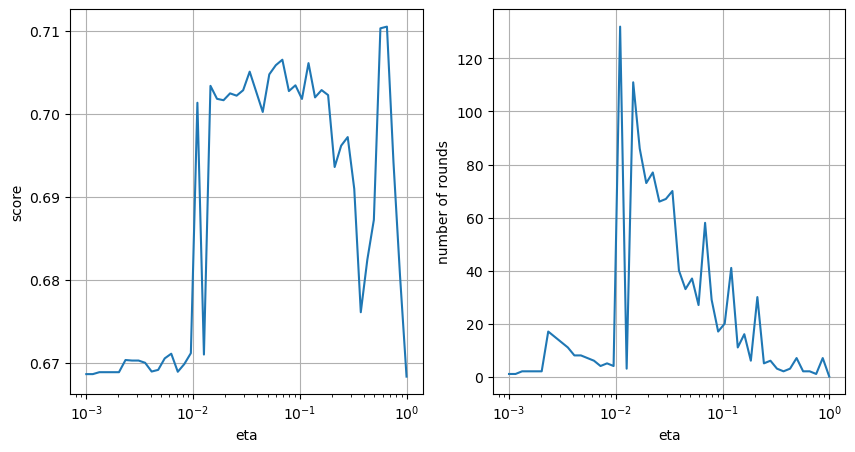

In [20]:
%%time
best_scores = []
num_rounds = []
etas = np.logspace(-3,0,50)
for eta in etas:
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2,
        early_stopping_rounds=10 ,
        eta = eta , n_estimators=500 , 
        eval_metric= 'auc' )

    xgb_model.fit(X_train , y_train  , 
                  eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  verbose=False )

    best_scores.append( xgb_model.best_score )
    num_rounds.append( xgb_model.best_iteration )

fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].plot( etas , best_scores )
ax[0].set_xlabel('eta')
ax[0].set_ylabel('score')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].plot( etas , num_rounds )
ax[1].set_xlabel('eta')
ax[1].set_ylabel('number of rounds')
ax[1].set_xscale('log')
ax[1].grid()


## exercise: 

Test the effect of the `subsample` parameter on XGboost

CPU times: user 3.9 s, sys: 4.04 ms, total: 3.91 s
Wall time: 629 ms


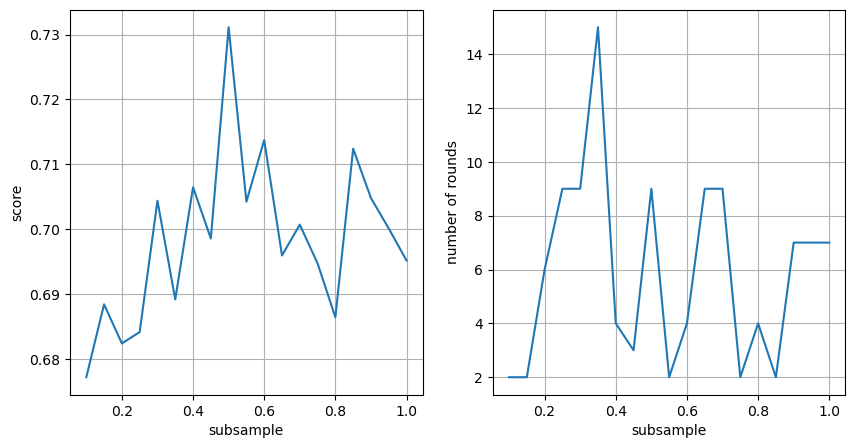

In [21]:
%%time
## tentative correction

best_scores = []
num_rounds = []
eta = 0.3
subsamples = np.arange(0.1,1.01,0.05)
for subsample in subsamples:
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2,
        early_stopping_rounds=10 ,
        eta = eta, 
        subsample = subsample,
        eval_metric= 'auc' )

    xgb_model.fit(X_train , y_train  , 
                  eval_set=[(X_train, y_train),(X_valid, y_valid)],
                  verbose=False )

    best_scores.append( xgb_model.best_score )
    num_rounds.append( xgb_model.best_iteration )

fig,ax=plt.subplots(1,2,figsize = (10,5))
ax[0].plot( subsamples , best_scores )
ax[0].set_xlabel('subsample')
ax[0].set_ylabel('score')
ax[0].grid()

ax[1].plot( subsamples , num_rounds )
ax[1].set_xlabel('subsample')
ax[1].set_ylabel('number of rounds')
ax[1].grid()


#some (some of) XGBoost hyper-parameters to control overfitting

from the [recommendations on controling overfitting from the documentation](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html#control-overfitting)



 * The first way is to directly control model complexity.
     * This includes `max_depth`, `min_child_weight` and `gamma`.

 * The second way is to add randomness to make training robust to noise.
     * This includes `subsample` and `colsample_bytree`.
     * You can also reduce stepsize `eta`. Remember to increase `num_round` when you do so.


We have already looked at `eta` and `subsample` together.


## max_depth

max_depth (Optional[int]) – Maximum tree depth for base learners.

In [22]:
# let's make a helper function to facilitate our work
def test_param( param_name, param_values, **kwargs ):

    best_scores_val = []
    best_scores_train = []
  
    for value in param_values:
        xgb_model = xgb.XGBClassifier(
            n_jobs=multiprocessing.cpu_count()-2,
            early_stopping_rounds=10 ,
            eval_metric= 'auc',
            **kwargs,
            **{param_name:value} 
        )

        xgb_model.fit(X_train , y_train  , 
                      eval_set=[(X_train, y_train),(X_valid, y_valid)],
                      verbose=False )

        best_scores_val.append( xgb_model.best_score )
        best_scores_train.append( xgb_model.evals_result_['validation_0']['auc'][xgb_model.best_iteration] )
        


    return param_values , best_scores_val , best_scores_train

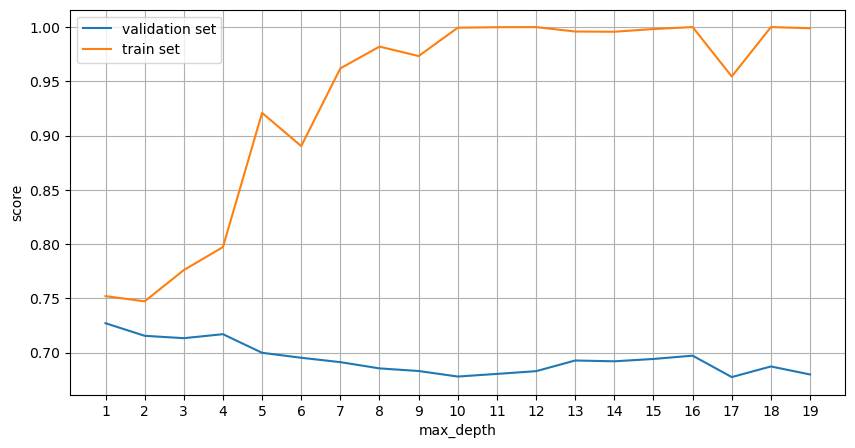

In [23]:
pname = 'max_depth'
pvals = np.arange(1,20)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals )
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## gamma

gamma (Optional[float]) – (min_split_loss) Minimum loss reduction required to make a further partition on a leaf node of the tree.

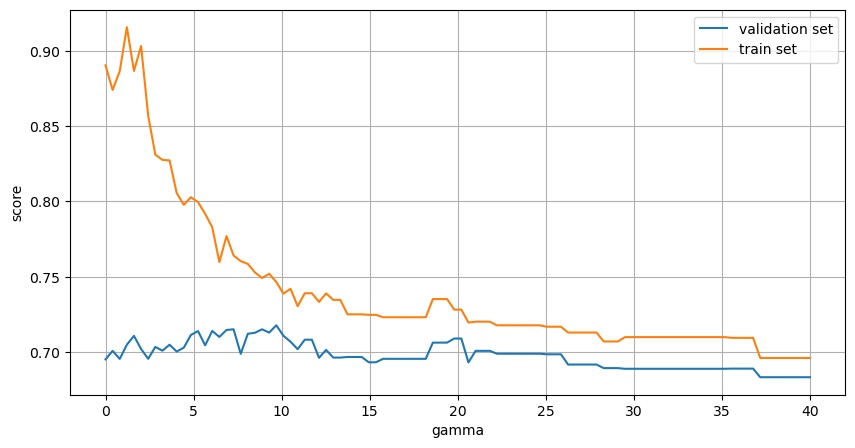

In [24]:
pname = 'gamma'
pvals = np.linspace(0.0,40,100)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals )
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## min_child_weight

min_child_weight (Optional[float]) – Minimum sum of instance weight(hessian) needed in a child.

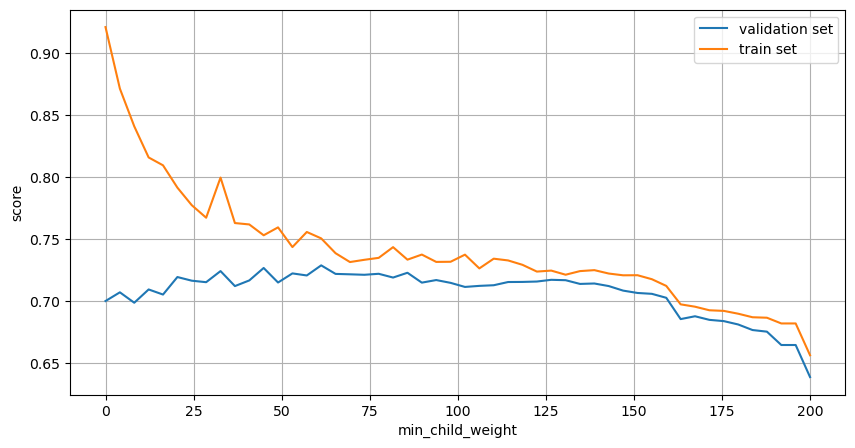

In [25]:
pname = 'min_child_weight'
pvals = np.linspace(0.0,200,50)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals )
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

## colsample_bytree

colsample_bytree (Optional[float]) – Subsample ratio of columns when constructing each tree.

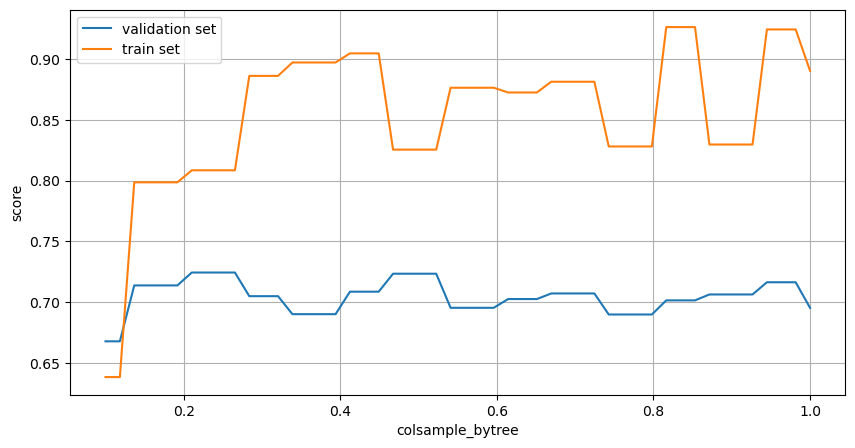

In [26]:
pname = 'colsample_bytree'
pvals = np.linspace(0.1,1.0,50)

param_values , best_scores_val , best_scores_train = test_param( pname, pvals )
fig,ax=plt.subplots(1,1,figsize = (10,5))
ax.plot( param_values , best_scores_val , label = 'validation set' )
ax.plot( param_values , best_scores_train , label = 'train set' )
#ax.set_xticks( param_values )
ax.set_xlabel(pname)
ax.set_ylabel('score')
ax.grid()
ax.legend()

And these are just some of the main hyper-parameters.

**micro-exercise:**
what may be missing from the hyper-parameter explorations we have done here?

answer: we have mostly looked at the HP one-by-one, but all of these interact and thus cannot by tuned one-by-one.


# Annex : 

I put here some additional remarks and tricks

## Imbalance

https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html#handle-imbalanced-dataset

the documentation recommends to use `scale_pos_weight`, which corresponds to the re-weigthing of the positive calss samples

typical value num_negative_samples / num_positive_samples

Let's try it out:

In [28]:
from sklearn.datasets import make_classification

B = 0.99
X , y = make_classification(n_samples=3*10**3 , weights=[B,1-B])

Xt, Xv, yt, yv = train_test_split(X, y, stratify=y, random_state=89)

num_pos = yt.sum()

xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2, 
    early_stopping_rounds=10 ,
    eval_metric= 'auc',
    scale_pos_weight =  (len(yt) - num_pos) / num_pos )


xgb_model.fit(Xt , yt  , 
                  eval_set=[(Xt, yt),(Xv, yv)],
                  verbose=False )
print( xgb_model.best_score )

pd.crosstab( yv,  xgb_model.predict( Xv ) ,  rownames=['true'], colnames=['predicted'] )

0.6831756756756757


predicted,0,1
true,,
0,729,11
1,6,4


In [29]:
%%time

prop_zeros = np.logspace( np.log10(0.5) , np.log10(1-10**-3) , 50 )
auc_no_weights = []
auc_with_weights = []
recall_with_weight = []
recall_no_weight = []

for B in prop_zeros:
    X , y = make_classification(n_samples=3*10**3 , weights=[B,1-B])

    Xt, Xv, yt, yv = train_test_split(X, y, stratify=y, random_state=89)

    num_pos = yt.sum()

    ## with weights
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2, 
        early_stopping_rounds=10 ,
        eval_metric= 'auc',
        scale_pos_weight = (len(yt) - num_pos) / num_pos )


    xgb_model.fit(Xt , yt  , 
                      eval_set=[(Xt, yt),(Xv, yv)],
                      verbose=False )
    auc_with_weights.append( xgb_model.best_score )
    recall_with_weight.append( ( xgb_model.predict( Xv )[yv==1] ==1 ).mean() )
    ## without weights
    xgb_model = xgb.XGBClassifier(
        n_jobs=multiprocessing.cpu_count()-2, 
        early_stopping_rounds=10 ,
        eval_metric= 'auc')


    xgb_model.fit(Xt , yt  , 
                      eval_set=[(Xt, yt),(Xv, yv)],
                      verbose=False )
    auc_no_weights.append( xgb_model.best_score )
    
    recall_no_weight.append( ( xgb_model.predict( Xv )[yv==1] ==1 ).mean() )


CPU times: user 37.4 s, sys: 160 ms, total: 37.6 s
Wall time: 6.04 s


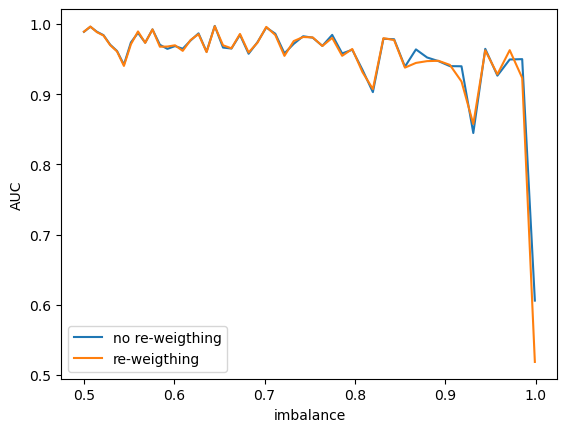

In [30]:
plt.plot( prop_zeros , auc_no_weights , label="no re-weigthing" )
plt.plot( prop_zeros , auc_with_weights , label="re-weigthing" )
plt.xlabel('imbalance')
plt.ylabel('AUC')
plt.legend()

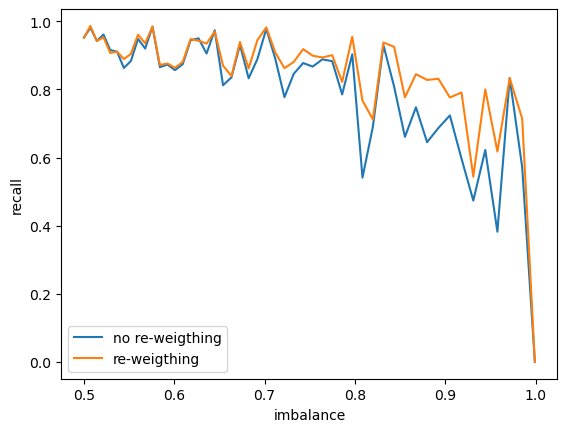

In [31]:
plt.plot( prop_zeros , recall_no_weight , label="no re-weigthing" )
plt.plot( prop_zeros , recall_with_weight , label="re-weigthing" )
plt.xlabel('imbalance')
plt.ylabel('recall')
plt.legend()

The effect is not extremely clear here, but recall tends to be better.

## trick: continuing training 

In [32]:
xgb_model = xgb.XGBClassifier(
    n_jobs=multiprocessing.cpu_count()-2,
    tree_method="hist" , eta = 0.3 , n_estimators=32  )

xgb_model.fit(X_train , y_train)

xgb_model.get_booster().num_boosted_rounds()

xgb_model.fit(X_train , y_train  ,xgb_model=xgb_model )

print( xgb_model.get_booster().num_boosted_rounds() )

64
